# Fish Image Classification Using ANN

This notebook implements an Artificial Neural Network (ANN) model to classify different species of fish using images from the Large-Scale Fish Dataset.

## 1. Importing Necessary Libraries

In this section, we import all required libraries for data handling, image processing, model creation, and visualization.

In [34]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

## 2. Data Preparation

This step collects the paths of the fish images and their corresponding labels, storing them in a DataFrame for easy manipulation and analysis.

In [35]:
# Extracting image paths and labels
label = []
path = []
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            if dir_name.split('/')[-1] != 'GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))

data = pd.DataFrame({'path': path, 'label': label})

# Display the first few rows of the data
print(data.head())
data.info()

                                                path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    18000 non-null  object
 1   label   18000 non-null  object
dtypes: object(2)
memory usage: 281.4+ KB


## 3. Visualizing Sample Images and Class Distribution

This step provides a visual representation of the data, displaying sample images for each fish class and showing the distribution of classes to identify potential imbalances.

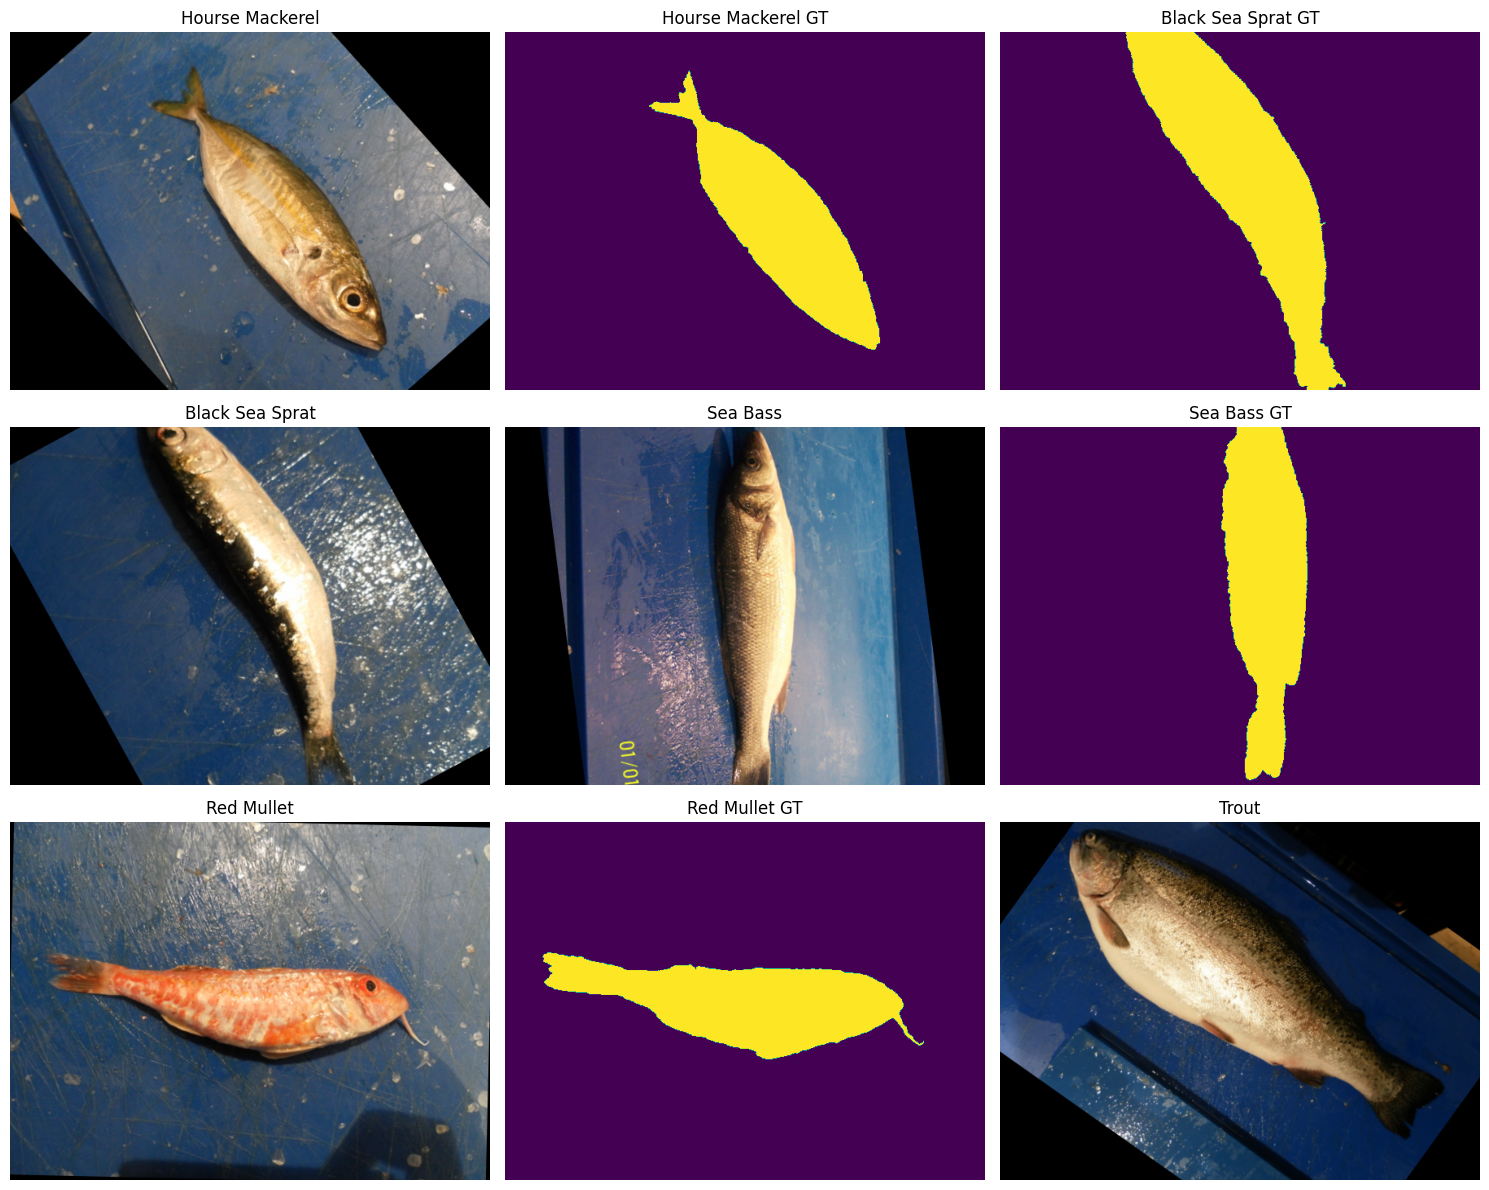

In [30]:
# Visualizing sample images with aspect ratio
plt.figure(figsize=(15, 12))
unique_labels = data['label'].unique()[:9]  # Display only the first 9 labels

for idx, unique_label in enumerate(unique_labels):
    plt.subplot(3, 3, idx + 1)
    label_data = data[data['label'] == unique_label]
    
    if not label_data.empty:
        img_path = label_data.iloc[0, 0]
        img = plt.imread(img_path)
        plt.imshow(img, aspect='auto')  # Maintain aspect ratio
        plt.title(unique_label)
    else:
        plt.text(0.5, 0.5, 'No Image', ha='center', va='center', fontsize=12)
        plt.title(unique_label + ' (No Image)')
    
    plt.axis('off')

plt.tight_layout()
plt.show()


## 4. Data Splitting and Augmentation

The dataset is split into training and testing sets, and image augmentation techniques are applied to increase the variability of the training data, which helps improve model generalization.

In [31]:
# Splitting the data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

# Data Augmentation for the training set
train_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)    
val_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)    
test_generator = ImageDataGenerator(rescale=1./255)

# Loading the images using flow_from_dataframe
train_images = train_generator.flow_from_dataframe(
    dataframe=train_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=True, 
    seed=42, 
    subset='training'
)

val_images = val_generator.flow_from_dataframe(
    dataframe=train_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=True, 
    seed=42, 
    subset='validation' 
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=False 
)


Found 11520 validated image filenames belonging to 18 classes.
Found 2880 validated image filenames belonging to 18 classes.
Found 3600 validated image filenames belonging to 18 classes.


## 5. Building the ANN Model

This step builds the ANN model, defining the architecture with input, hidden, and output layers. Regularization techniques like dropout and L2 regularization help reduce overfitting.

In [32]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 3))) 

# Hidden Layers
model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))

# Output Layer
model.add(tf.keras.layers.Dense(len(train_images.class_indices), activation='softmax'))

model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1024)           │     2,409,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,114,066 (11.88 MB)

 Trainable params: 3,110,994 (11.87 MB)

 Non-trainable params: 3,072 (12.00 KB)

## 6. Model Compilation and Training

The model is compiled and trained using the training dataset. The callbacks for early stopping and learning rate adjustment help optimize training and prevent overfitting. The model's performance is evaluated based on validation metrics during training.

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    if epoch >= 20:
        lr *= 0.990 
    return lr

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Compiling the model
model.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training the model
results = model.fit(
    train_images, 
    epochs=100, 
    batch_size=64, 
    validation_data=val_images,
    callbacks=[early_stopping, lr_scheduler_callback]
)


Epoch 1/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 146s 777ms/step - accuracy: 0.2506 - loss: 4.9482 - val_accuracy: 0.3896 - val_loss: 4.3548 - learning_rate: 0.0100
Epoch 2/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 91s 491ms/step - accuracy: 0.5092 - loss: 4.0072 - val_accuracy: 0.5962 - val_loss: 3.7472 - learning_rate: 0.0100
Epoch 3/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 90s 485ms/step - accuracy: 0.5832 - loss: 3.7222 - val_accuracy: 0.6542 - val_loss: 3.5056 - learning_rate: 0.0100
Epoch 4/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 91s 490ms/step - accuracy: 0.6489 - loss: 3.5179 - val_accuracy: 0.6979 - val_loss: 3.3387 - learning_rate: 0.0100
Epoch 5/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 91s 489ms/step - accuracy: 0.6936 - loss: 3.3374 - val_accuracy: 0.6826 - val_loss: 3.3111 - learning_rate: 0.0100
Epoch 6/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 90s 487ms/step - accuracy: 0.7068 - loss: 3.2439 - val_accuracy: 0.7142 - val_loss: 3.1840 - learning_rate: 0.0100
Epoch 7/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 90s 486ms/step - accur

## 7. Evaluate the Model

After training, we evaluate the model on the test data to assess its performance.

In [36]:
# Evaluate on the test data
test_loss, test_accuracy = model.evaluate(test_images)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 514ms/step - accuracy: 0.8296 - loss: 1.9056
Test Loss: 1.8362361192703247, Test Accuracy: 0.8405555486679077


## 8. Confusion Matrix and Classification Report

By generating the classification report and visualizing the confusion matrix, we gain valuable insights into the model's strengths and weaknesses. This step is crucial for understanding how well the model performs across different fish species, allowing for targeted improvements and optimizations in future iterations of the model.

57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 378ms/step


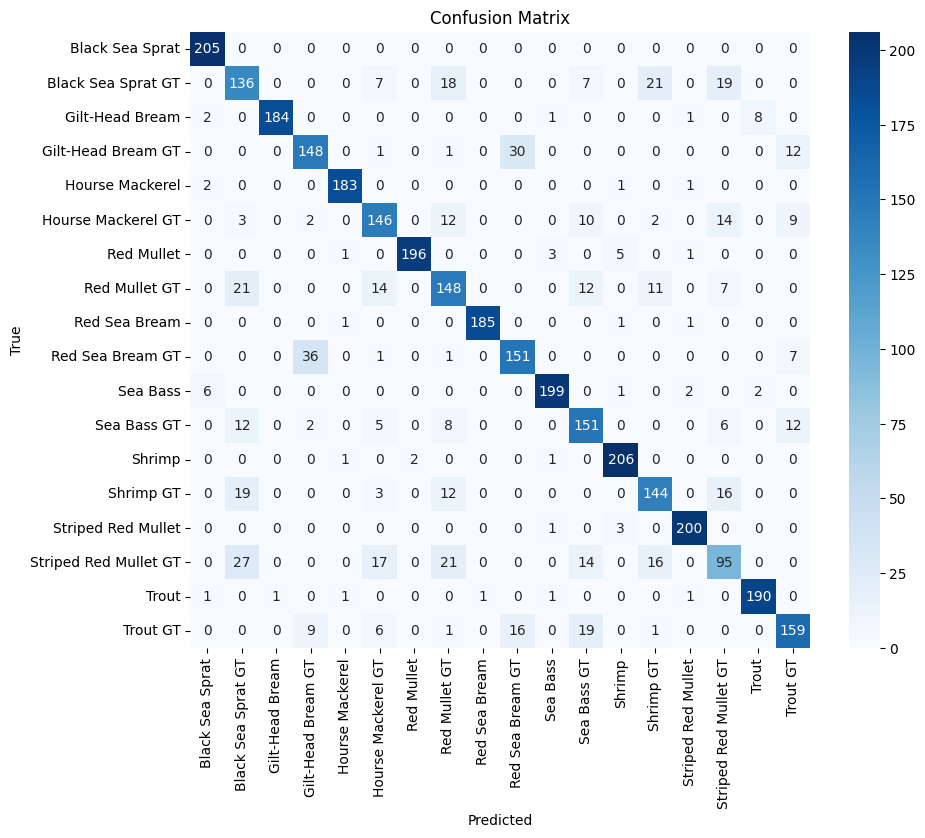

                       precision    recall  f1-score   support

      Black Sea Sprat       0.95      1.00      0.97       205
   Black Sea Sprat GT       0.62      0.65      0.64       208
      Gilt-Head Bream       0.99      0.94      0.97       196
   Gilt-Head Bream GT       0.75      0.77      0.76       192
      Hourse Mackerel       0.98      0.98      0.98       187
   Hourse Mackerel GT       0.73      0.74      0.73       198
           Red Mullet       0.99      0.95      0.97       206
        Red Mullet GT       0.67      0.69      0.68       213
        Red Sea Bream       0.99      0.98      0.99       188
     Red Sea Bream GT       0.77      0.77      0.77       196
             Sea Bass       0.97      0.95      0.96       210
          Sea Bass GT       0.71      0.77      0.74       196
               Shrimp       0.95      0.98      0.96       210
            Shrimp GT       0.74      0.74      0.74       194
   Striped Red Mullet       0.97      0.98      0.97  

In [37]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)
y_true = test_images.classes

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_images.class_indices.keys(), yticklabels=test_images.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))


## Overview

The Fish Image Classification project employs an Artificial Neural Network (ANN) to classify various species of fish based on images from the Large-Scale Fish Dataset. The project begins with importing essential libraries for data handling and visualization, followed by data preparation, where image paths and labels are extracted into a structured DataFrame. To better understand the dataset, sample images and their class distribution are visualized, helping to identify any imbalances that could impact model performance. The dataset is then split into training and testing sets, with data augmentation applied to enhance model generalization. An ANN model is constructed with multiple dense layers, incorporating dropout and batch normalization to mitigate overfitting. The model is compiled using the Adagrad optimizer and categorical crossentropy loss function, with early stopping and a learning rate scheduler implemented during training to optimize performance. After extensive training, the model achieves a test accuracy of approximately 84%, demonstrating its ability to effectively classify fish species from images.